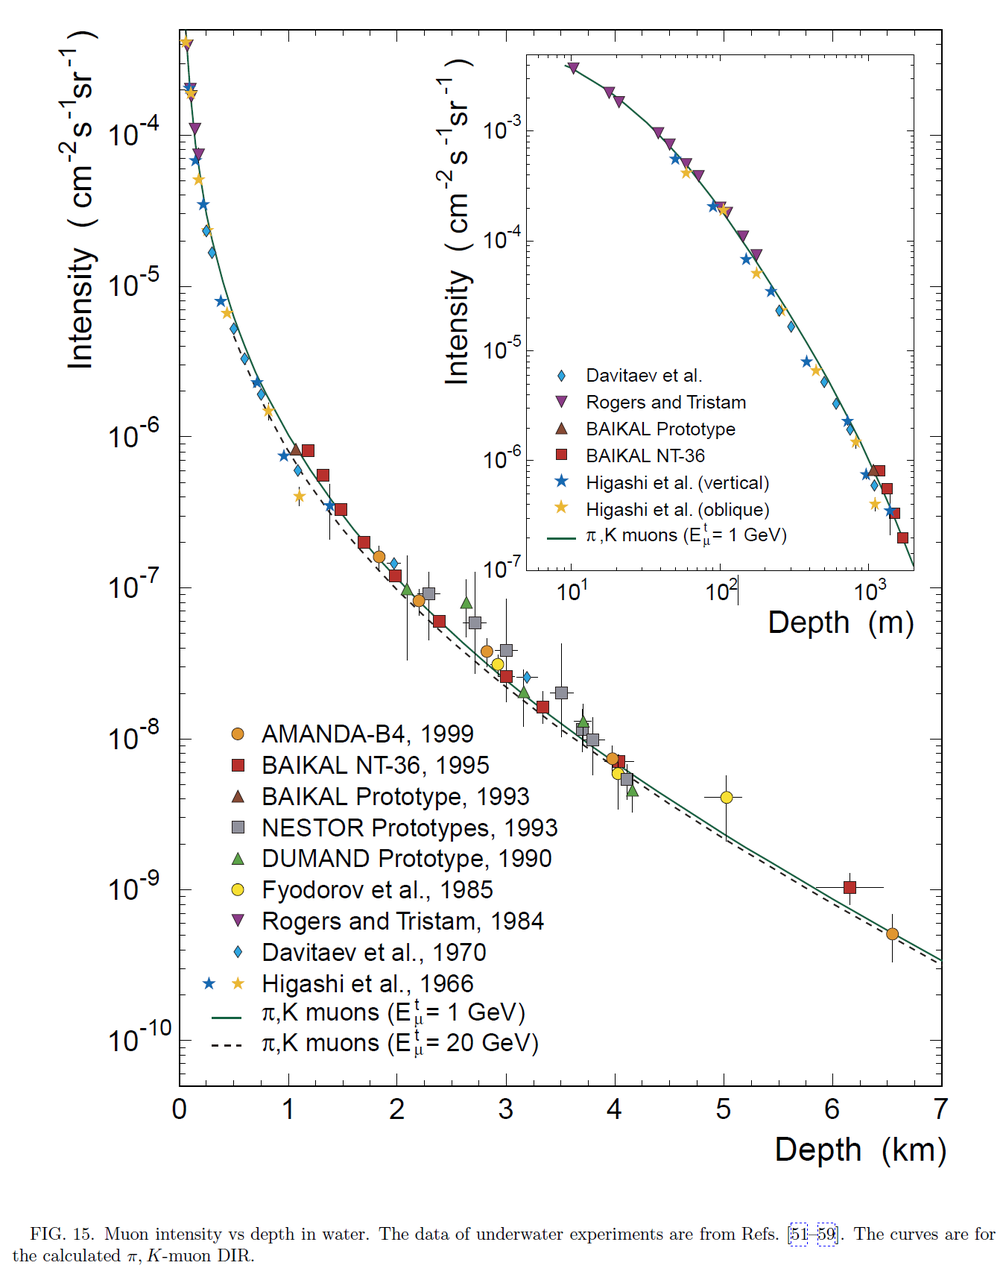

## From 0.01km - 1km

In [137]:
# Provided data points
depth = np.array([10, 20, 50, 100, 200, 300, 500, 1000])
intensity = np.array([3e-3, 2e-3, 4e-4, 1e-4, 3e-5, 1e-5, 4e-6, 8e-7])

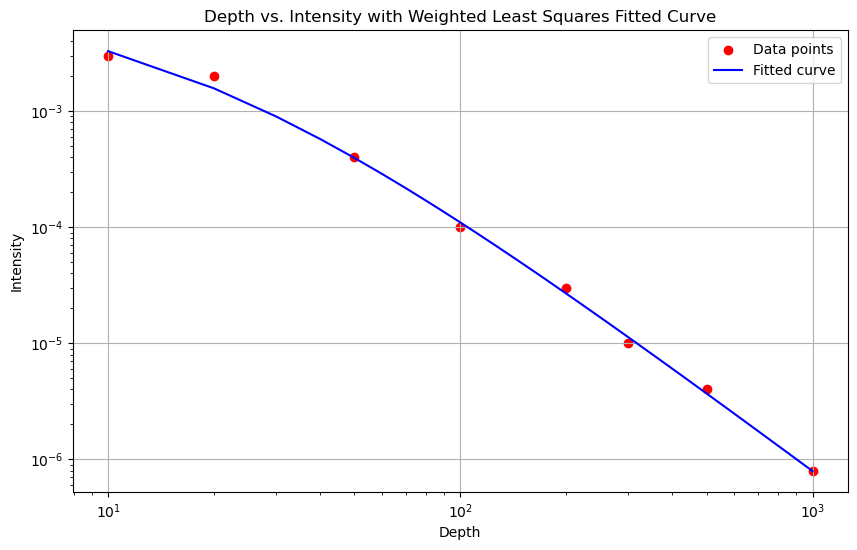

a_fit: 5.438135608992032
b_fit: 2.273762841829212
c_fit: 16.03277980802706


In [138]:
# Define the model function
def modified_model_func_v2(depth, a, b, c):
    return a * (depth + c) ** -b

# Define a more robust model function that ensures valid values during the fit
def modified_model_func_v2_safe(depth, a, b, c):
    depth_safe = np.maximum(depth + c, 1e-10)  # ensure no negative or zero values inside the power
    return a * depth_safe ** -b

# Define the weights (inverse of intensity to give more weight to smaller values)
weights = 1 / intensity

# Define the weighted residuals function for least_squares with weights
def weighted_residuals(params, depth, intensity, weights):
    a, b, c = params
    return weights * (modified_model_func_v2_safe(depth, a, b, c) - intensity)

# Initial guess
initial_guess = [1e-3, 1, 10]

# Perform least squares fitting with weights
result = least_squares(weighted_residuals, initial_guess, args=(depth, intensity, weights), max_nfev=10000)

# Get the fitted parameters
a_fit, b_fit, c_fit = result.x

# Generate fitted curve
depth_fit = np.linspace(min(depth), max(depth), 100)
intensity_fit = modified_model_func_v2_safe(depth_fit, a_fit, b_fit, c_fit)

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(depth, intensity, color='red', label='Data points')
plt.plot(depth_fit, intensity_fit, color='blue', label='Fitted curve')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Depth')
plt.ylabel('Intensity')
plt.title('Depth vs. Intensity with Weighted Least Squares Fitted Curve')
plt.legend()
plt.grid(True)
plt.show()

# Output the fitted parameters
print(f"a_fit: {a_fit}")
print(f"b_fit: {b_fit}")
print(f"c_fit: {c_fit}")


## From 1 km - 3.5 km 

/var/folders/wc/kx_rrh_j1f3bnmx46n6k6zg80000gn/T/ipykernel_9203/1642962186.py:3: RuntimeWarning: invalid value encountered in power
  return a * (depth + c) ** -b


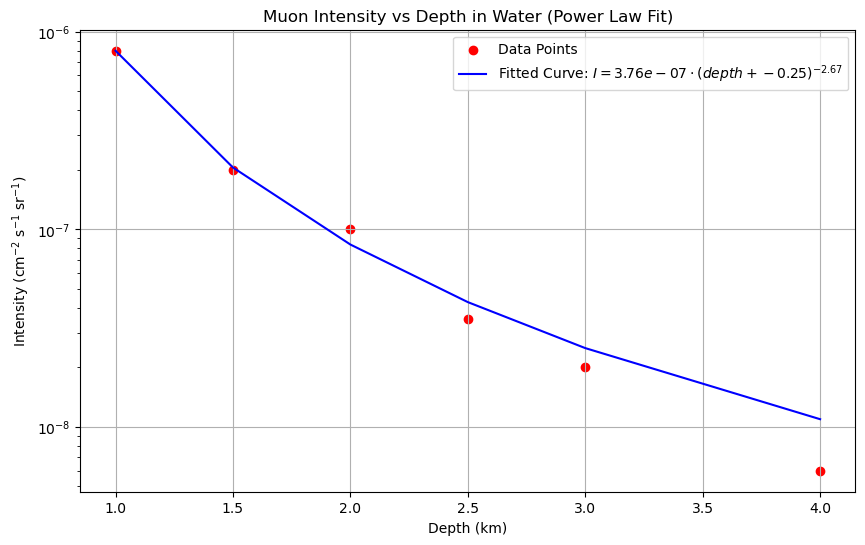

array([ 3.75655909e-07,  2.67372562e+00, -2.46183913e-01])

In [140]:
# Define an alternative function to fit (power-law decay)
def muon_intensity_power_law(depth, a, b, c):
    return a * (depth + c) ** -b

# Data points extracted from the plot (approximate values)
depth = np.array([1, 1.5, 2, 2.5, 3, 4])  # in km
intensity = np.array([8e-7, 2e-7, 1e-7, 3.5e-8, 2e-8, 6e-9])  # in cm^-2 s^-1 sr^-1

# Fit the curve using the alternative function
params_power_law, covariance_power_law = curve_fit(muon_intensity_power_law, depth, intensity, p0=[1e-4, 1, 1])

# Plot the data points and the fitted curve with the alternative function
plt.figure(figsize=(10, 6))
plt.scatter(depth, intensity, label='Data Points', color='red')
plt.plot(depth, muon_intensity_power_law(depth, *params_power_law), label=f'Fitted Curve: $I = {params_power_law[0]:.2e} \cdot (depth + {params_power_law[2]:.2f})^{{-{params_power_law[1]:.2f}}}$', color='blue')
plt.yscale('log')
plt.xlabel('Depth (km)')
plt.ylabel('Intensity (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.title('Muon Intensity vs Depth in Water (Power Law Fit)')
plt.legend()
plt.grid(True)
plt.show()

params_power_law

In [175]:
cost = 15 # W
power = 2.5 # kWh
detector_area = 400 # Effective area of the detector in cm^2
depth_ranges = [(0, 0.01), (0.01, 0.1), (0.1, 1), (1, 3.5)] # Depth ranges and corresponding times
speed = 0.003 # falling speed in km/s
steps = 1000

In [176]:
import numpy as np
from scipy.integrate import quad
import pandas as pd

def power_to_days(cost, power):

    # power in unit of kWh
    days = power * 1000 / 24 / cost
    return days

# Function for the parameterized muon flux
def muon_flux(depth):
    if depth > 1:
        return 3.76e-7 * (depth - 0.25) ** -2.67 # because of fitting, two sets of ranges
    else:
        return modified_model_func_v2_safe(depth*1000, 5.438, 2.274, 16.033) # because of fitting, two sets of ranges

times = []
for depth_range in depth_ranges:
    times.append( (depth_range[1] - depth_range[0])/speed )

# Function to calculate the muon counts over a given depth range using fine steps
def calculate_muon_counts(depth_range, speed, steps):
    d_start, d_end = depth_range
    step_size = (d_end - d_start) / steps
    total_muons = 0
    
    for step in range(steps):
        depth = d_start + step * step_size
        next_depth = depth + step_size
        avg_flux = (muon_flux(depth) + muon_flux(next_depth)) / 2
        time_spent = step_size / speed
        muons_in_step = avg_flux * detector_area * time_spent
        total_muons += muons_in_step
    
    return total_muons

# Calculate muon counts for each depth range
muon_counts_fine_steps = [calculate_muon_counts(depth_range, speed, steps) for depth_range in depth_ranges]

# For the last step, staying at 3500m for x days
days = power_to_days(cost, power)
depth_3500m_flux = muon_flux(3.5)
muon_count_3500m = depth_3500m_flux * detector_area * days * 24 * 3600
muon_counts_fine_steps.append(muon_count_3500m)

# Prepare the results in a dataframe
df_muon_counts_fine_steps = pd.DataFrame({
    "Depth Range (km)": depth_ranges + [3.5],
    "Time (s)": times + [days*24*3600],
    "Muon Counts": muon_counts_fine_steps
})

print (f"Detector surface area is: {detector_area}cm^2\n")
print (f"At {speed} km/s falling speed\n")
print (f"With power consumption of {cost}W and battery capaticy of {power}kWh, system will last for {np.floor(days)} days before dying\n")

df_muon_counts_fine_steps

Detector surface area is: 400cm^2

At 0.003 km/s falling speed

With power consumption of 15W and battery capaticy of 2.5kWh, system will last for 6.0 days before dying



,Depth Range (km),Time (s),Muon Counts
0,"(0, 0.01)",3.333333,7.646465
1,"(0.01, 0.1)",30.000000,7.616871
2,"(0.1, 1)",300.000000,1.249306
3,"(1, 3.5)",833.333333,0.044339
4,3.5,600000.000000,3.878560


In [177]:
muon_flux(0.2)

2.6714097303658243e-05

In [178]:
0.02/0.003*0.0007*400

1.866666666666667